In [5]:
pip install entsoe-py


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 40.0 MB/s eta 0:00:00


In [6]:


# fetch_and_train.py

import pandas as pd
from datetime import datetime, timedelta
from entsoe import EntsoePandasClient
import requests
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import joblib

# --------------------------
# Config
# --------------------------
ENTSOE_TOKEN = "5810c760-66e1-422e-981a-e9dcd36f52c8"  # Your actual token
COUNTRY_CODE = "FR"  # France has good data availability
LAT, LON = 49.8153, 6.1296  # Coordinates (Luxembourg in this example)

# Initialize ENTSO-E client
client = EntsoePandasClient(api_key=ENTSOE_TOKEN)

# --------------------------
# Fetch historic electricity prices from ENTSO-E
# --------------------------
def fetch_entsoe_prices(start_date, end_date):
    print("⚡ Fetching electricity prices from ENTSO-E...")
    start = pd.Timestamp(start_date, tz="Europe/Paris")  # Paris timezone for France
    end = pd.Timestamp(end_date, tz="Europe/Paris")
    df = client.query_day_ahead_prices(country_code=COUNTRY_CODE, start=start, end=end)
    df = df.reset_index()
    df.columns = ["time", "price"]
    # price is in EUR/MWh, convert to €/MWh (keep as is, no divide by 1000 needed)
    df["time"] = pd.to_datetime(df["time"])
    return df



# --------------------------
# Fetch weather from Open-Meteo
# --------------------------
def fetch_weather(start_date, end_date):
    print("🌤️ Fetching weather data from Open-Meteo...")
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": LAT,
        "longitude": LON,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m,cloudcover,shortwave_radiation,wind_speed_10m",
        "timezone": "Europe/Berlin"
    }
    r = requests.get(url, params=params)
    data = r.json()
    if "hourly" not in data:
        raise ValueError(f"Open-Meteo API response missing 'hourly' data: {data}")
    df = pd.DataFrame(data["hourly"])
    df["time"] = pd.to_datetime(df["time"])
    return df

# --------------------------
# Train model
# --------------------------
def train_model():
    print("📥 Fetching data...")

    end_date = datetime.utcnow()
    start_date = end_date - timedelta(days=10)

    start_str = start_date.strftime("%Y-%m-%d")
    end_str = end_date.strftime("%Y-%m-%d")

    price_df = fetch_entsoe_prices(start_str, end_str)
    weather_df = fetch_weather(start_str, end_str)

    # Make timezone consistent for merging:
    price_df['time'] = price_df['time'].dt.tz_convert('UTC')
    weather_df['time'] = weather_df['time'].dt.tz_localize(None).dt.tz_localize('UTC')

    # Merge datasets on time
    df = price_df.merge(weather_df, on="time", how="inner")

    # Feature engineering
    df["hour"] = df["time"].dt.hour
    df["dayofweek"] = df["time"].dt.dayofweek
    df["month"] = df["time"].dt.month
    df["lag1"] = df["price"].shift(1)
    df["lag24"] = df["price"].shift(24)
    df = df.dropna()



    # Note: Use the correct weather feature names matching your fetched data
    features = [
        "temperature_2m",
        "cloudcover",
        "shortwave_radiation",
        "wind_speed_10m",
        "hour",
        "dayofweek",
        "month",
        "lag1",
        "lag24",
    ]

    X = df[features]
    y = df["price"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

    print("🧠 Training model...")
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print(f"📉 MAE: {mean_absolute_error(y_test, y_pred):.4f} €/MWh")
    joblib.dump(model, "xgb_model_price.pkl")
    print("✅ Model saved to xgb_model_price.pkl")
    return df

if __name__ == "__main__":
    df = train_model()


📥 Fetching data...
⚡ Fetching electricity prices from ENTSO-E...


/tmp/ipython-input-2117344999.py:66: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow()
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarni

🌤️ Fetching weather data from Open-Meteo...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

🧠 Training model...


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


📉 MAE: 7.3658 €/MWh
✅ Model saved to xgb_model_price.pkl


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


--- Data Analysis ---
Shape: (195, 11)

Sample rows:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,time,price,temperature_2m,cloudcover,shortwave_radiation,wind_speed_10m,hour,dayofweek,month,lag1,lag24
24,2025-09-07 00:00:00+00:00,-0.01,14.0,96.0,0.0,10.3,0,6,9,-0.01,41.35
25,2025-09-07 01:00:00+00:00,-0.01,13.5,92.0,0.0,9.2,1,6,9,-0.01,20.66
26,2025-09-07 02:00:00+00:00,-0.01,13.0,13.0,0.0,8.3,2,6,9,-0.01,20.00
27,2025-09-07 03:00:00+00:00,-0.01,12.1,90.0,0.0,7.0,3,6,9,-0.01,25.38
28,2025-09-07 04:00:00+00:00,0.00,11.6,99.0,0.0,6.9,4,6,9,-0.01,25.49


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


Summary statistics:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,price,temperature_2m,cloudcover,shortwave_radiation,wind_speed_10m,hour,dayofweek,month,lag1,lag24
count,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.000000,195.0,195.000000,195.000000
mean,24.338923,14.752821,77.671795,149.656410,11.843077,11.338462,3.323077,9.0,24.338923,24.994154
std,30.702419,3.413244,31.489238,203.560776,5.581162,7.007971,2.147459,0.0,30.702419,30.727823
min,-53.400000,8.300000,0.000000,0.000000,1.300000,0.000000,0.000000,9.0,-53.400000,-53.400000
25%,0.010000,12.000000,58.000000,0.000000,7.950000,5.000000,1.000000,9.0,0.010000,0.010000
50%,14.750000,14.600000,97.000000,15.000000,11.700000,11.000000,3.000000,9.0,14.750000,15.970000
75%,37.990000,16.300000,100.000000,305.000000,15.200000,17.000000,5.000000,9.0,37.990000,38.640000
max,111.370000,24.700000,100.000000,713.000000,25.500000,23.000000,6.000000,9.0,111.370000,111.370000



Missing values:
time                   0
price                  0
temperature_2m         0
cloudcover             0
shortwave_radiation    0
wind_speed_10m         0
hour                   0
dayofweek              0
month                  0
lag1                   0
lag24                  0
dtype: int64

Correlation with price:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,price
price,1.000000
lag1,0.893391
lag24,0.437456
temperature_2m,0.327765
hour,0.219756
shortwave_radiation,-0.123655
cloudcover,-0.198832
time,-0.339181
wind_speed_10m,-0.382198
dayofweek,-0.435847


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

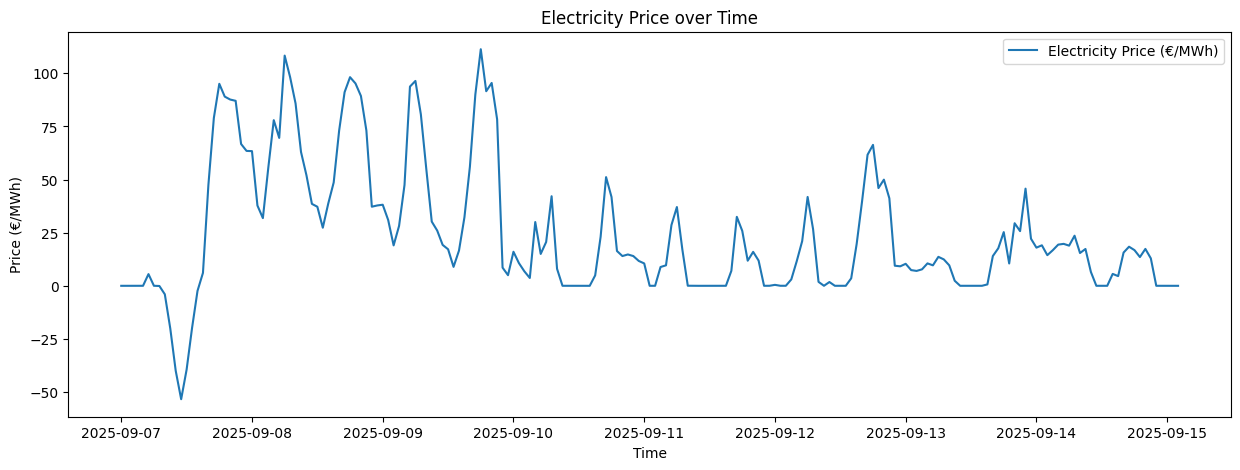

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

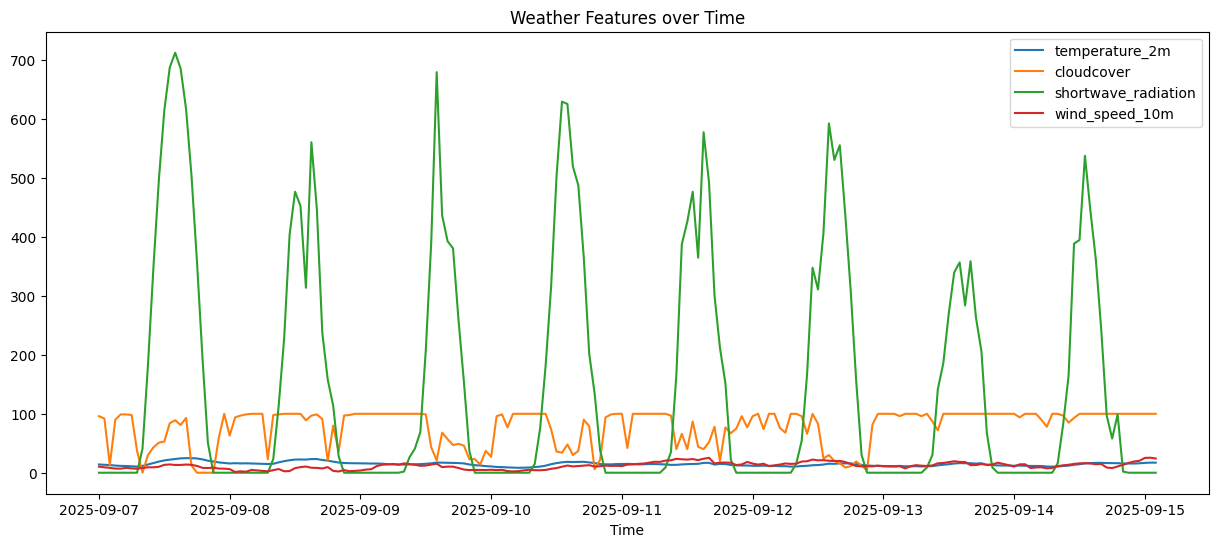

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

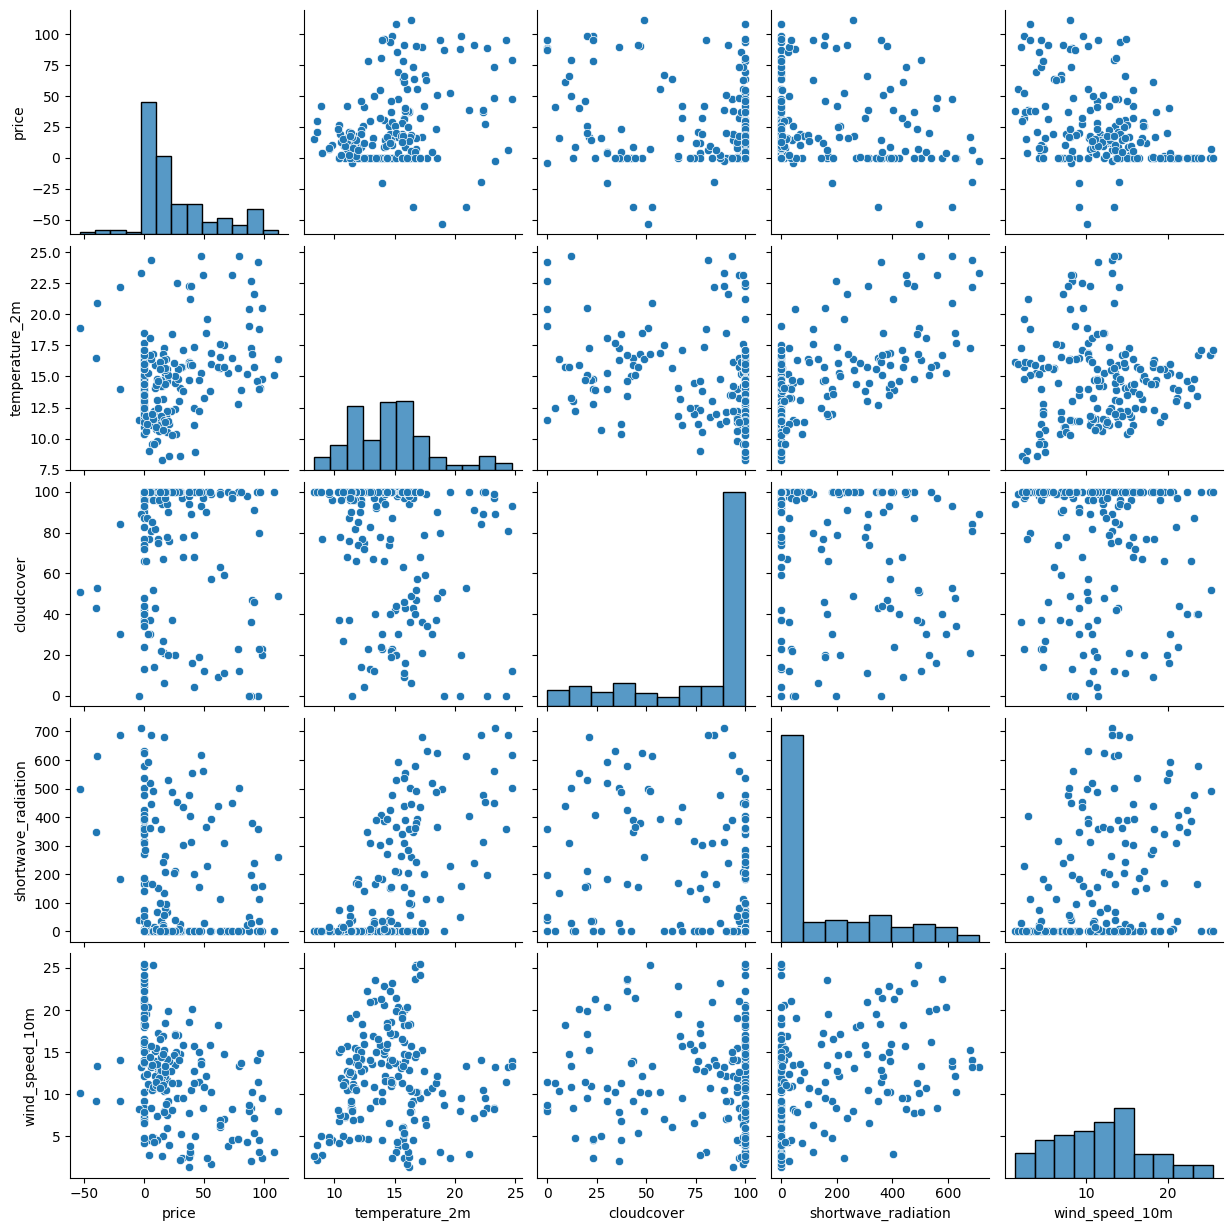

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_and_visualize(df):
    print("\n--- Data Analysis ---")
    print("Shape:", df.shape)
    print("\nSample rows:")
    display(df.head())

    print("\nSummary statistics:")
    display(df.describe())

    print("\nMissing values:")
    print(df.isnull().sum())

    print("\nCorrelation with price:")
    corr = df.corr()
    display(corr["price"].sort_values(ascending=False))

    # Time series plot of price
    plt.figure(figsize=(15, 5))
    plt.plot(df['time'], df['price'], label="Electricity Price (€/MWh)")
    plt.title("Electricity Price over Time")
    plt.xlabel("Time")
    plt.ylabel("Price (€/MWh)")
    plt.legend()
    plt.show()

    # Weather features over time
    plt.figure(figsize=(15, 6))
    for feature in ["temperature_2m", "cloudcover", "shortwave_radiation", "wind_speed_10m"]:
        plt.plot(df['time'], df[feature], label=feature)
    plt.title("Weather Features over Time")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

    # Pairplot (scatter matrix) to visualize relationships
    sns.pairplot(df, vars=["price", "temperature_2m", "cloudcover", "shortwave_radiation", "wind_speed_10m"])
    plt.show()

# Run the analysis function on your data
analyze_and_visualize(df)


In [1]:
!pip install statsmodels


In [2]:
# After merging and feature engineering, before dropna()



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

📊 PROFESSIONAL DATA ANALYSIS REPORT

▶️ Data Shape & Types:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Data Type,Missing Values,Unique Values
time,"datetime64[ns, UTC]",0,195
price,float64,0,152
temperature_2m,float64,0,93
cloudcover,float64,0,62
shortwave_radiation,float64,0,95
wind_speed_10m,float64,0,127
hour,int32,0,24
dayofweek,int32,0,7
month,int32,0,1
lag1,float64,0,152


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


▶️ First 10 rows of the dataset:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,time,price,temperature_2m,cloudcover,shortwave_radiation,wind_speed_10m,hour,dayofweek,month,lag1,lag24
24,2025-09-07 00:00:00+00:00,-0.01,14.0,96.0,0.0,10.3,0,6,9,-0.01,41.35
25,2025-09-07 01:00:00+00:00,-0.01,13.5,92.0,0.0,9.2,1,6,9,-0.01,20.66
26,2025-09-07 02:00:00+00:00,-0.01,13.0,13.0,0.0,8.3,2,6,9,-0.01,20.00
27,2025-09-07 03:00:00+00:00,-0.01,12.1,90.0,0.0,7.0,3,6,9,-0.01,25.38
28,2025-09-07 04:00:00+00:00,0.00,11.6,99.0,0.0,6.9,4,6,9,-0.01,25.49
29,2025-09-07 05:00:00+00:00,5.50,11.4,99.0,0.0,8.3,5,6,9,0.00,25.86
30,2025-09-07 06:00:00+00:00,0.00,10.9,98.0,0.0,7.3,6,6,9,5.50,29.28
31,2025-09-07 07:00:00+00:00,-0.09,10.4,37.0,0.0,6.8,7,6,9,0.00,15.23
32,2025-09-07 08:00:00+00:00,-4.00,11.5,0.0,41.0,8.2,8,6,9,-0.09,1.72
33,2025-09-07 09:00:00+00:00,-20.09,14.0,30.0,183.0,9.2,9,6,9,-4.00,0.00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


▶️ Statistical Summary (Numerical Columns):


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,count,mean,std,min,25%,50%,75%,max
price,195.000000,24.338923,30.702419,-53.400000,0.010000,14.750000,37.990000,111.370000
temperature_2m,195.000000,14.752821,3.413244,8.300000,12.000000,14.600000,16.300000,24.700000
cloudcover,195.000000,77.671795,31.489238,0.000000,58.000000,97.000000,100.000000,100.000000
shortwave_radiation,195.000000,149.656410,203.560776,0.000000,0.000000,15.000000,305.000000,713.000000
wind_speed_10m,195.000000,11.843077,5.581162,1.300000,7.950000,11.700000,15.200000,25.500000
hour,195.000000,11.338462,7.007971,0.000000,5.000000,11.000000,17.000000,23.000000
dayofweek,195.000000,3.323077,2.147459,0.000000,1.000000,3.000000,5.000000,6.000000
month,195.000000,9.000000,0.000000,9.000000,9.000000,9.000000,9.000000,9.000000
lag1,195.000000,24.338923,30.702419,-53.400000,0.010000,14.750000,37.990000,111.370000
lag24,195.000000,24.994154,30.727823,-53.400000,0.010000,15.970000,38.640000,111.370000


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


▶️ Time Series Decomposition of Price:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

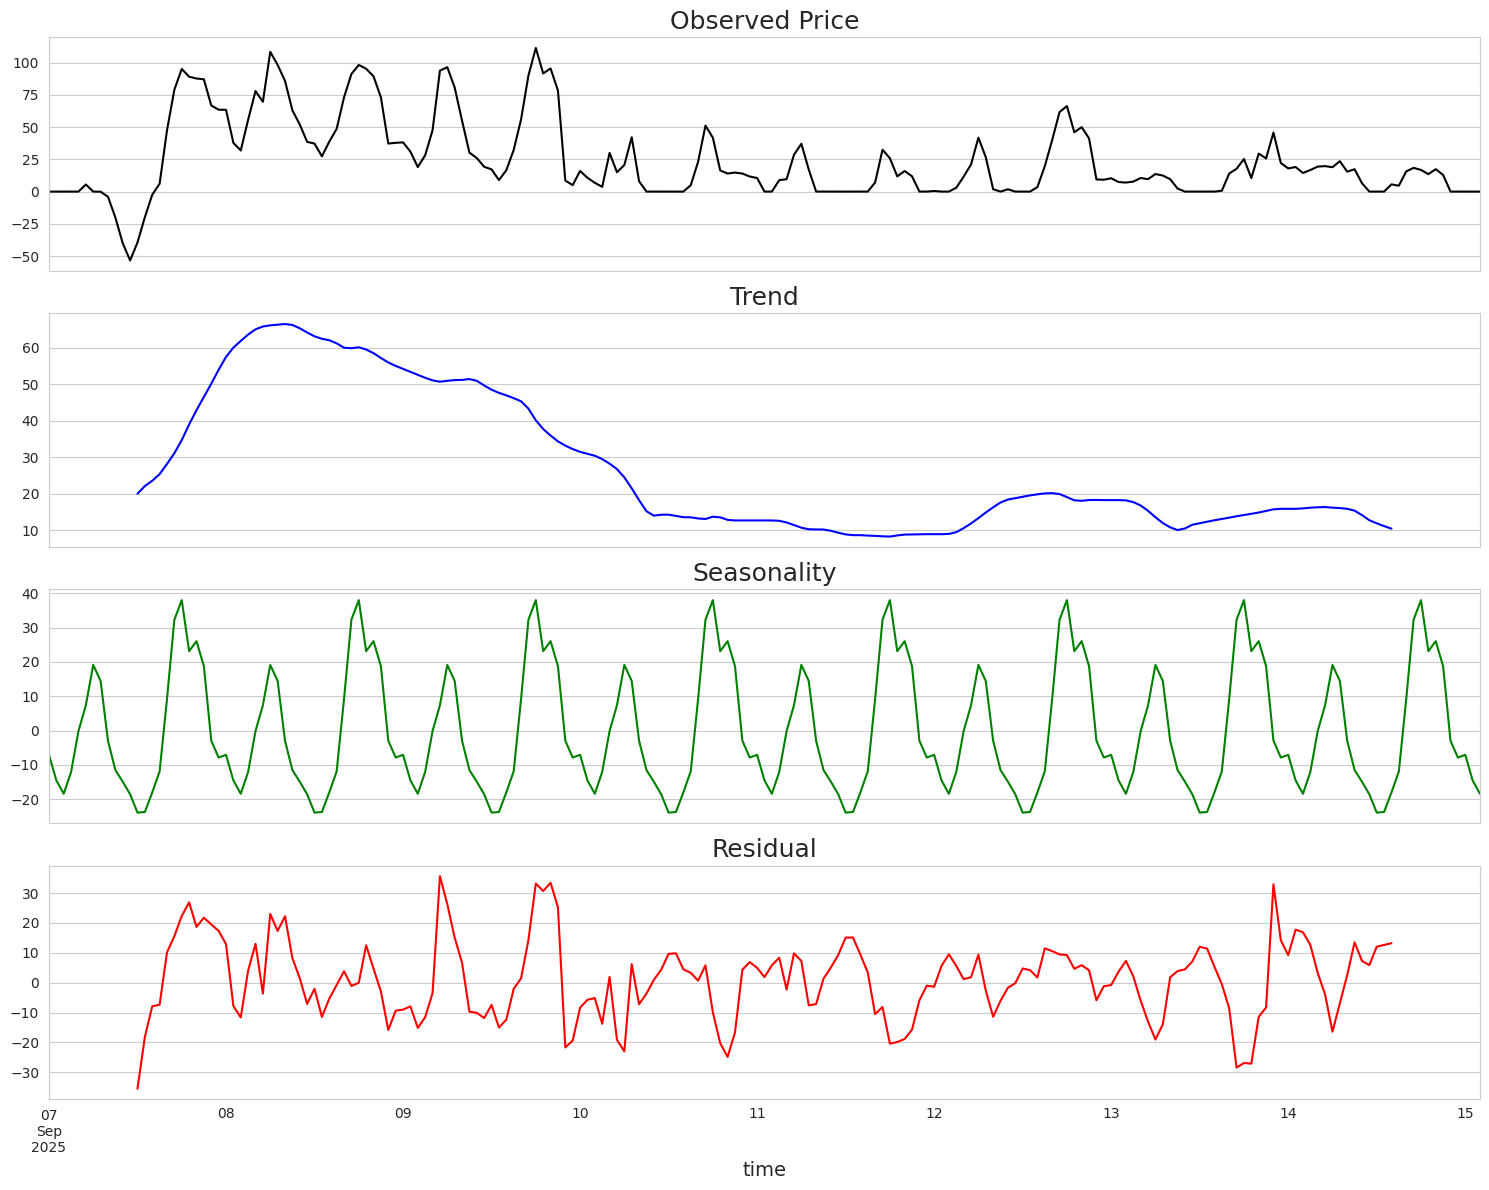

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag


▶️ Feature Correlation Heatmap:


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

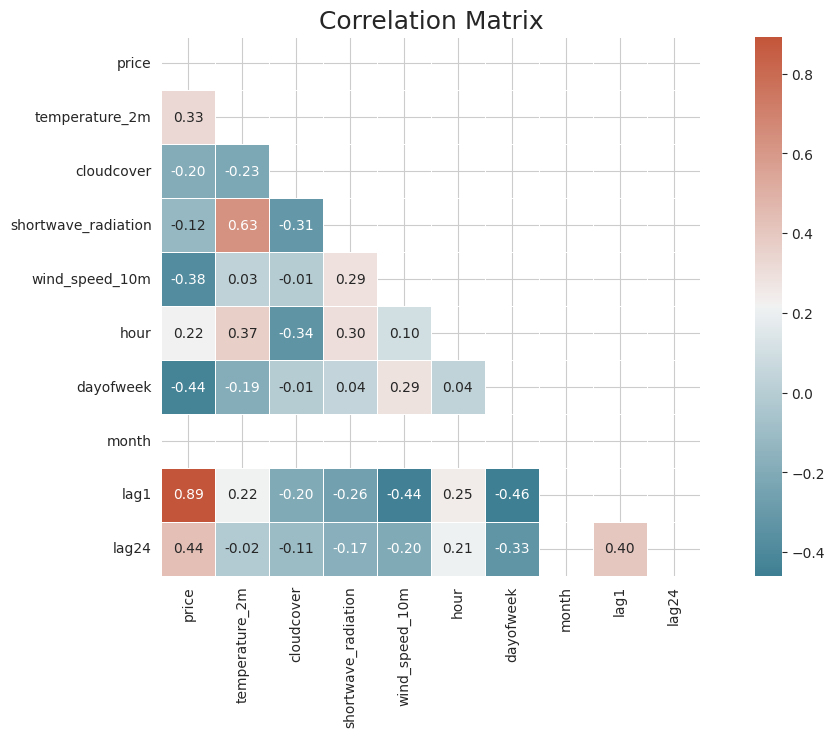

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

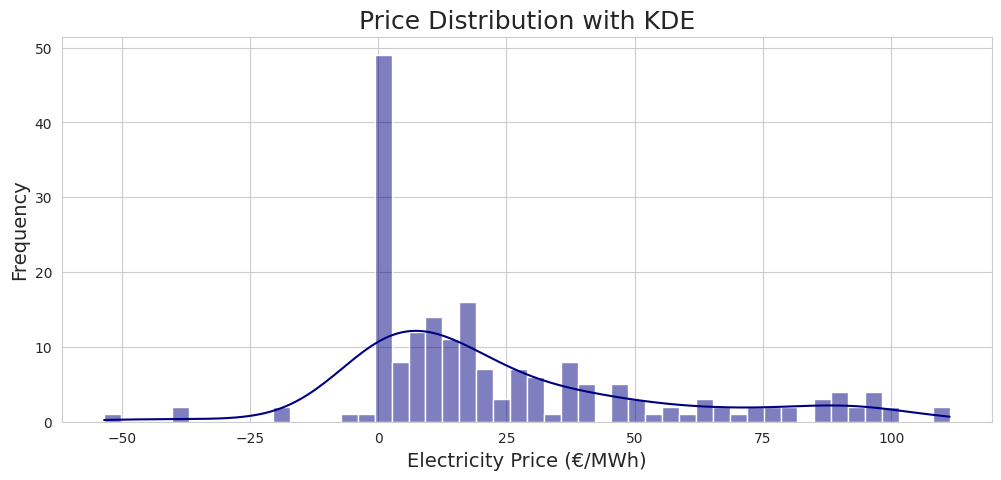

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

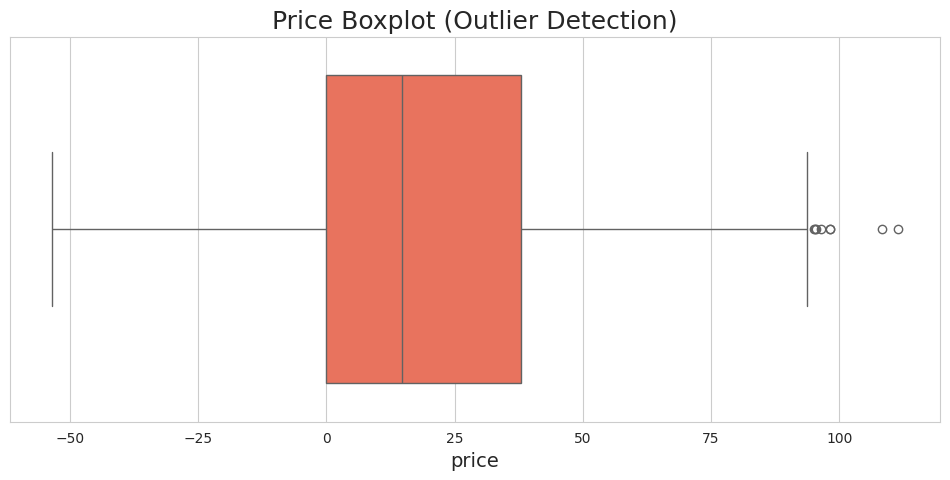

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2063119681.py:69: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df, x='hour', y='price', ci='sd', marker='o', color='darkcyan')
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and schedule

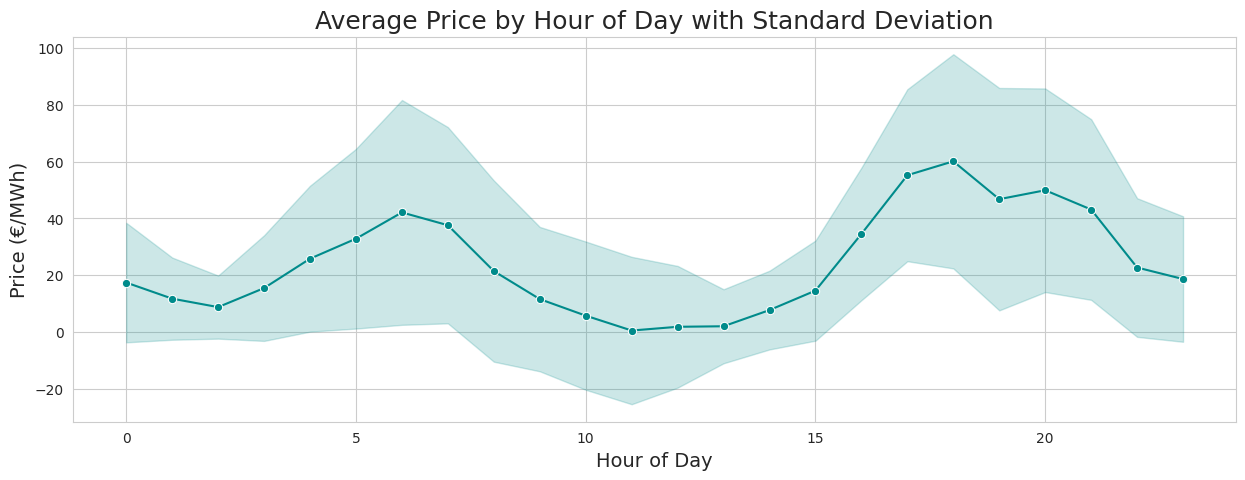

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/tmp/ipython-input-2063119681.py:76: 

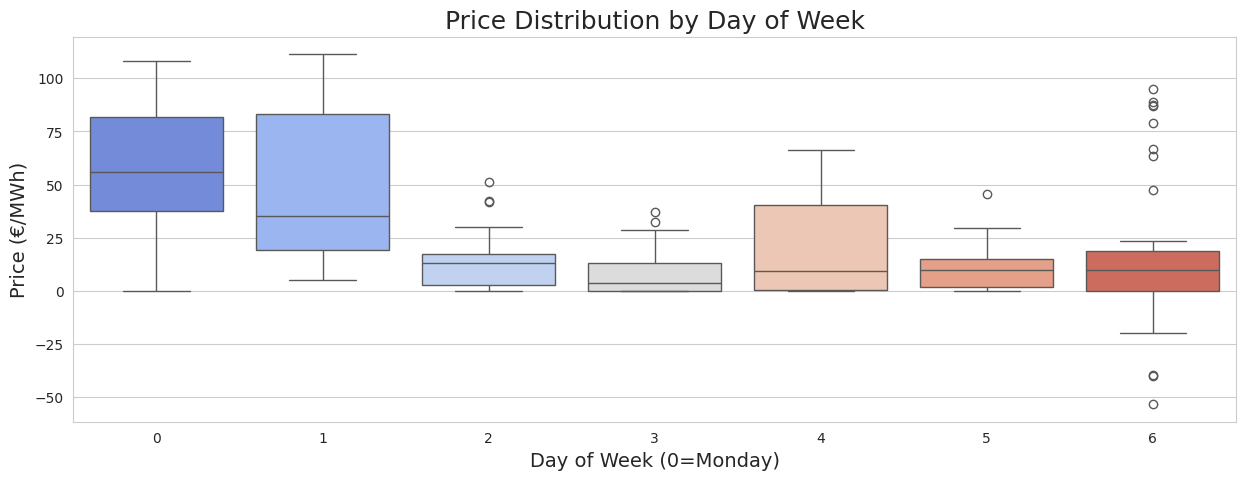

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

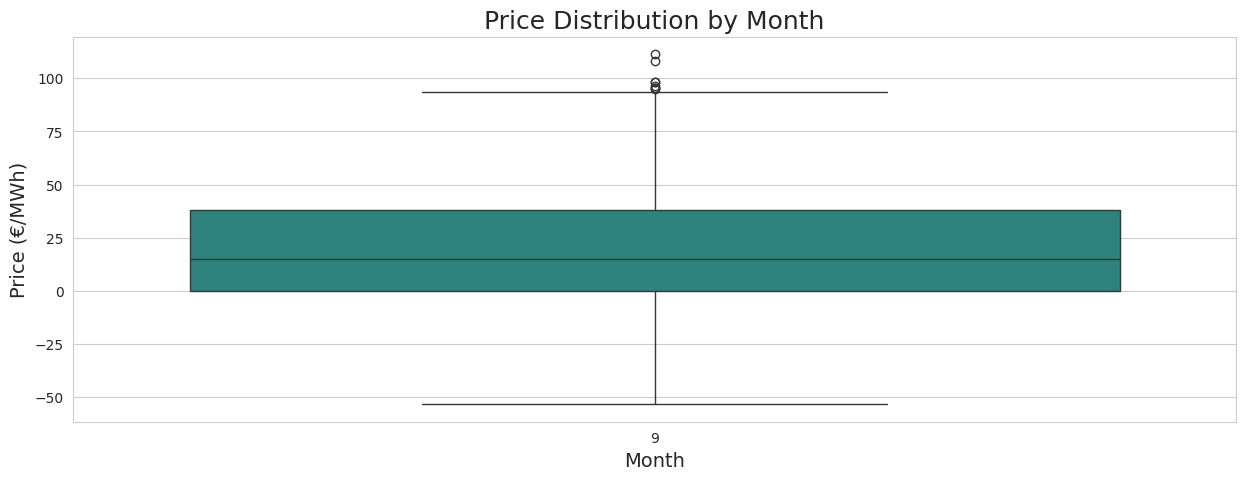

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

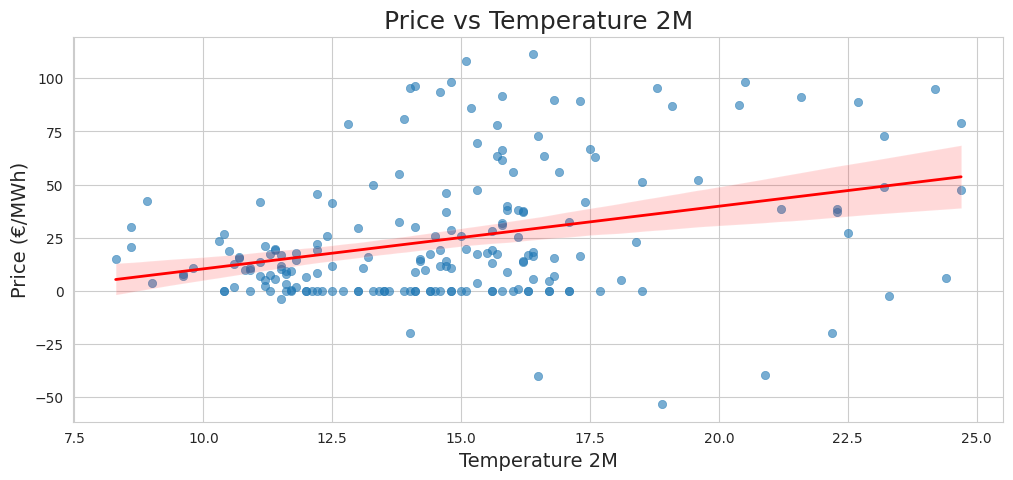

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

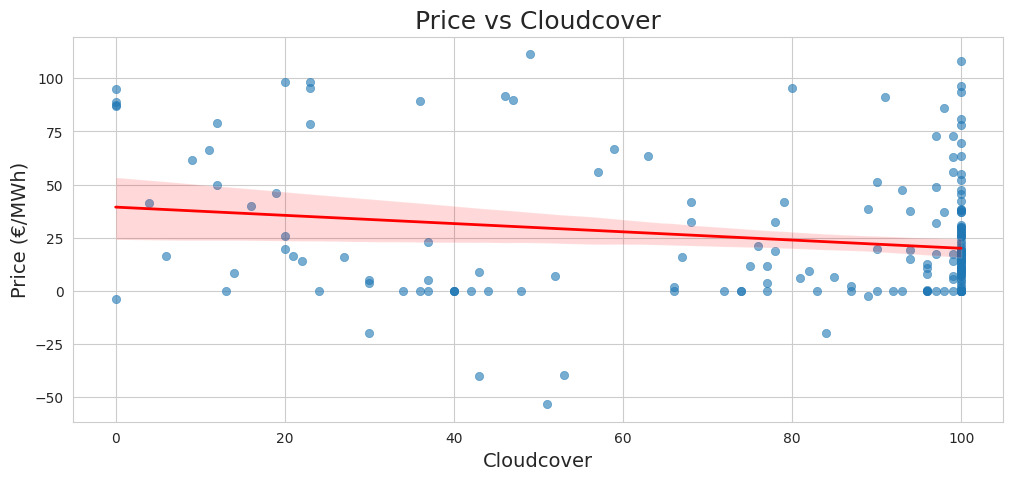

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

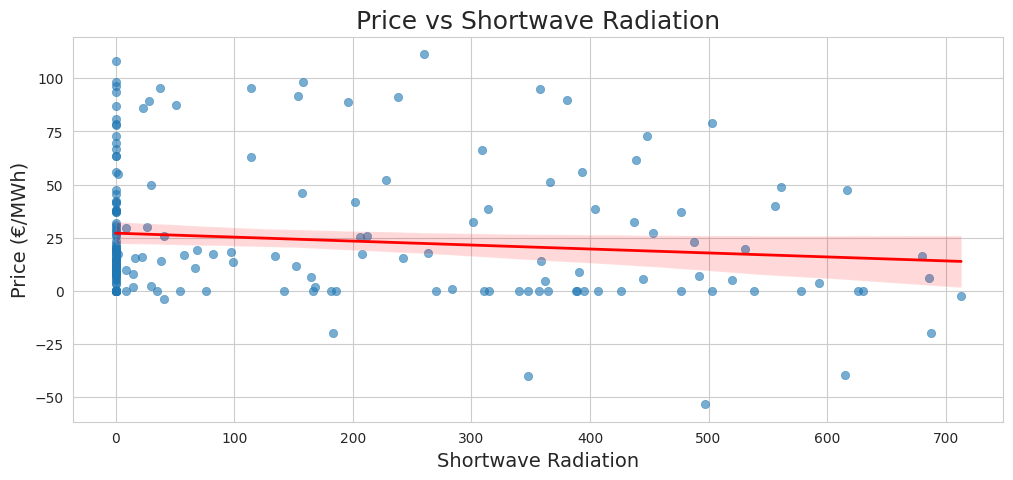

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

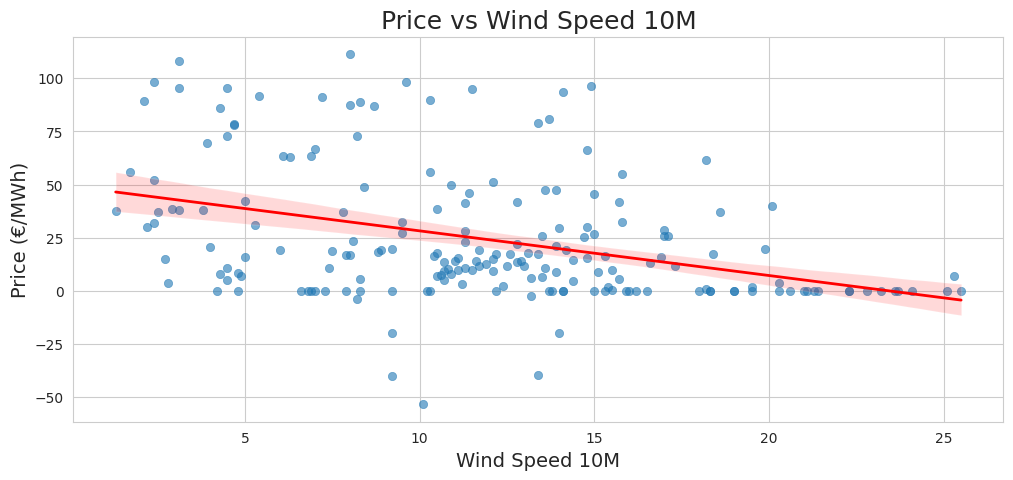


✅ Data analysis complete. Ready for modeling and insights!



/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, HTML

def professional_data_analysis(df):
    sns.set_style("whitegrid")
    plt.rcParams.update({'figure.figsize': (14, 7), 'axes.titlesize': 18, 'axes.labelsize': 14})

    print("="*80)
    print("📊 PROFESSIONAL DATA ANALYSIS REPORT")
    print("="*80)

    # --- 1. Data overview ---
    print("\n▶️ Data Shape & Types:")
    display(pd.DataFrame({
        "Data Type": df.dtypes,
        "Missing Values": df.isna().sum(),
        "Unique Values": df.nunique()
    }).style.background_gradient(cmap="Blues"))

    print("\n▶️ First 10 rows of the dataset:")
    display(df.head(10))

    # --- 2. Statistical summary ---
    print("\n▶️ Statistical Summary (Numerical Columns):")
    display(df.describe().T.style.background_gradient(cmap='YlGn'))

    # --- 3. Time series decomposition ---
    try:
        from statsmodels.tsa.seasonal import seasonal_decompose
        print("\n▶️ Time Series Decomposition of Price:")
        decomposition = seasonal_decompose(df.set_index('time')['price'].sort_index(), model='additive', period=24)
        fig, axes = plt.subplots(4, 1, sharex=True, figsize=(15, 12))
        decomposition.observed.plot(ax=axes[0], color='black', title='Observed Price')
        decomposition.trend.plot(ax=axes[1], color='blue', title='Trend')
        decomposition.seasonal.plot(ax=axes[2], color='green', title='Seasonality')
        decomposition.resid.plot(ax=axes[3], color='red', title='Residual')
        plt.tight_layout()
        plt.show()
    except ImportError:
        print("statsmodels is not installed. Install it via `pip install statsmodels` for advanced decomposition.")

    # --- 4. Correlation heatmap ---
    print("\n▶️ Feature Correlation Heatmap:")
    corr = df.select_dtypes(include=[np.number]).corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, fmt=".2f", square=True, linewidths=.5)
    plt.title("Correlation Matrix")
    plt.show()

    # --- 5. Price Distribution & Outliers ---
    plt.figure(figsize=(12,5))
    sns.histplot(df['price'], bins=50, kde=True, color='navy')
    plt.title('Price Distribution with KDE')
    plt.xlabel('Electricity Price (€/MWh)')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(12,5))
    sns.boxplot(x=df['price'], color='tomato')
    plt.title('Price Boxplot (Outlier Detection)')
    plt.show()

    # --- 6. Seasonality visualizations ---
    plt.figure(figsize=(15,5))
    sns.lineplot(data=df, x='hour', y='price', ci='sd', marker='o', color='darkcyan')
    plt.title("Average Price by Hour of Day with Standard Deviation")
    plt.xlabel("Hour of Day")
    plt.ylabel("Price (€/MWh)")
    plt.show()

    plt.figure(figsize=(15,5))
    sns.boxplot(data=df, x='dayofweek', y='price', palette="coolwarm")
    plt.title("Price Distribution by Day of Week")
    plt.xlabel("Day of Week (0=Monday)")
    plt.ylabel("Price (€/MWh)")
    plt.show()

    plt.figure(figsize=(15,5))
    sns.boxplot(data=df, x='month', y='price', palette="viridis")
    plt.title("Price Distribution by Month")
    plt.xlabel("Month")
    plt.ylabel("Price (€/MWh)")
    plt.show()

    # --- 7. Relationships between weather features and price ---
    weather_features = ["temperature_2m", "cloudcover", "shortwave_radiation", "wind_speed_10m"]
    for feature in weather_features:
        plt.figure(figsize=(12,5))
        sns.scatterplot(x=df[feature], y=df['price'], alpha=0.6, edgecolor=None)
        sns.regplot(x=df[feature], y=df['price'], scatter=False, color='red', line_kws={'lw':2})
        plt.title(f"Price vs {feature.replace('_', ' ').title()}")
        plt.xlabel(feature.replace('_', ' ').title())
        plt.ylabel("Price (€/MWh)")
        plt.show()

    print("\n✅ Data analysis complete. Ready for modeling and insights!\n")

# Run this with your df in the next Colab cell:
professional_data_analysis(df)


In [ ]:
# pip install entsoe-py

In [16]:
from entsoe import EntsoePandasClient
import pandas as pd
import requests
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz

# Set up ENTSO-E credentials and client
API_KEY = "5810c760-66e1-422e-981a-e9dcd36f52c8"  # Replace this if needed
client = EntsoePandasClient(api_key=API_KEY)

COUNTRY_CODE = "LU"  # 🇱🇺 Luxembourg
LATITUDE = 49.6116
LONGITUDE = 6.1319
TIMEZONE = "Europe/Luxembourg"

def fetch_demand(start_date, end_date):
    print("⚡ Fetching electricity demand from ENTSO-E...")
    demand = client.query_load(country_code=COUNTRY_CODE, start=start_date, end=end_date)
    df = demand.reset_index()
    df.columns = ["time", "demand"]
    df["time"] = pd.to_datetime(df["time"])
    return df

def fetch_weather(start_date, end_date, latitude=LATITUDE, longitude=LONGITUDE):
    print("🌤️ Fetching weather data from Open-Meteo...")
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date.date().isoformat(),
        "end_date": end_date.date().isoformat(),
        "hourly": "temperature_2m,cloudcover,windspeed_10m",
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    data = response.json()

    if "hourly" not in data:
        raise ValueError(f"Open-Meteo API error: {data}")

    weather_df = pd.DataFrame(data["hourly"])
    weather_df["time"] = pd.to_datetime(weather_df["time"])
    return weather_df

def train_model():
    print("📥 Fetching data...")

    # Define time range (timezone-aware)
    tz = pytz.timezone(TIMEZONE)
    start_date = tz.localize(pd.Timestamp("2025-07-01"))
    end_date = tz.localize(pd.Timestamp("2025-07-05"))

    # Fetch data
    demand_df = fetch_demand(start_date, end_date)
    weather_df = fetch_weather(start_date, end_date)

    demand_df['time'] = demand_df['time'].dt.tz_localize(None)
    weather_df['time'] = weather_df['time'].dt.tz_localize(None)

    print("🔗 Merging data...")
    merged = pd.merge(demand_df, weather_df, on="time", how="inner")

    print("🧼 Cleaning and preparing data...")
    merged = merged.dropna()

    merged.to_csv("merged_demand_weather_luxembourg.csv", index=False)

    # Only use available features
    features = merged[["temperature_2m", "cloudcover", "windspeed_10m"]]
    target = merged["demand"]

    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

    print("🧠 Training model to predict demand...")
    model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)
    model.fit(X_train, y_train)

    print("📊 Evaluating model...")
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"📉 MAE: {mae:.2f} MW")

    print("💾 Saving model...")
    model.save_model("xgb_model_demand_luxembourg.pkl")

    print("📈 Plotting actual vs predicted demand...")
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values[:100], label="Actual Demand", marker="o")
    plt.plot(y_pred[:100], label="Predicted Demand", marker="x")
    plt.legend()
    plt.title("Electricity Demand Prediction for Luxembourg")
    plt.xlabel("Sample")
    plt.ylabel("Demand (MW)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("✅ All done.")

if __name__ == "__main__":
    train_model()


📥 Fetching data...
⚡ Fetching electricity demand from ENTSO-E...
🌤️ Fetching weather data from Open-Meteo...
🔗 Merging data...
🧼 Cleaning and preparing data...


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [17]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import xgboost as xgb
import numpy as np



model = xgb.XGBRegressor()
model.load_model("/content/xgb_model_demand_luxembourg.pkl")  # or .json if that's what you saved
# Load the test data used during training (you must have saved it or keep it consistent)
data = pd.read_csv("merged_demand_weather_luxembourg.csv", parse_dates=["time"])
data.set_index("time", inplace=True)

# Feature engineering (same as training)
features = ["temperature_2m", "cloudcover", "windspeed_10m"]

target = "demand"

X = data[features]
y = data[target]

split_index = int(0.8 * len(data))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Predict
y_pred = model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n📊 Model Evaluation:")
print(f"✅ MAE:  {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ R²:   {r2:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual Demand", color='blue')
plt.plot(y_test.index, y_pred, label="Predicted Demand", color='orange')
plt.title("🔋 Actual vs Predicted Electricity Demand")
plt.xlabel("Time")
plt.ylabel("Demand (MW)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

if __name__ == "__main__":
    train_model()

XGBoostError: [15:30:12] /workspace/dmlc-core/src/io/local_filesys.cc:210: Check failed: allow_null:  LocalFileSystem::Open "/content/xgb_model_demand_luxembourg.pkl": No such file or directory
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x7bef0c8a6e7c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x10d986d) [0x7bef0d6d986d]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x10c5c85) [0x7bef0d6c5c85]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterLoadModel+0x29b) [0x7bef0c7c1a0b]
  [bt] (4) /lib/x86_64-linux-gnu/libffi.so.8(+0x7e2e) [0x7bef523b5e2e]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.8(+0x4493) [0x7bef523b2493]
  [bt] (6) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x98c1) [0x7bef535d98c1]
  [bt] (7) /usr/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x8ffe) [0x7bef535d8ffe]
  [bt] (8) /usr/bin/python3(_PyObject_MakeTpCall+0x2db) [0x53d2ab]



In [11]:
print(data.columns.tolist())


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

NameError: name 'data' is not defined

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [18]:
import os
from datetime import datetime, timedelta
import pytz
import pandas as pd
import numpy as np
import requests
from entsoe import EntsoePandasClient
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt
import holidays
import logging
from joblib import dump, load
import warnings

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)
warnings.filterwarnings('ignore')

class AdvancedDemandForecaster:
    def __init__(self):
        self.config = {
            "entsoe_api_key": "5810c760-66e1-422e-981a-e9dcd36f52c8",
            "open_meteo_url": "https://api.open-meteo.com/v1/forecast",
            "country_code": "DE",
            "latitude": 52.52,
            "longitude": 13.405,
            "timezone": "Europe/Berlin",
            "n_historical_days": 30,  # Reduced to 30 days for testing
            "model_path": "models"
        }
        os.makedirs(self.config["model_path"], exist_ok=True)
        self.client = EntsoePandasClient(api_key=self.config["entsoe_api_key"])
        self.scaler = RobustScaler()
        self.models = {
            "xgb": xgb.XGBRegressor(),
            "rf": RandomForestRegressor()
        }
        self.df = None
        self.features = []

    def _ensure_timezone(self, dt):
        """Ensure datetime has correct timezone"""
        if isinstance(dt, str):
            dt = pd.to_datetime(dt)
        if not hasattr(dt, 'tzinfo') or dt.tzinfo is None:
            return dt.tz_localize(self.config["timezone"])
        return dt

    def _get_date_range(self):
        """Get timezone-aware date range"""
        tz = pytz.timezone(self.config["timezone"])
        end_date = datetime.now(tz)
        start_date = end_date - timedelta(days=self.config["n_historical_days"])
        return start_date, end_date

    def fetch_demand_data(self):
        """Fetch demand data with proper timezone handling"""
        logger.info("Fetching electricity demand data")
        start_date, end_date = self._get_date_range()

        try:
            # Get actual load
            demand = self.client.query_load(
                country_code=self.config["country_code"],
                start=self._ensure_timezone(start_date),
                end=self._ensure_timezone(end_date)
            ).reset_index()
            demand.columns = ["time", "actual_load"]
            demand["time"] = pd.to_datetime(demand["time"])
            return demand

        except Exception as e:
            logger.error(f"Error fetching demand data: {e}")
            raise

    def fetch_weather_data(self):
        """Fetch weather data"""
        logger.info("Fetching weather data")
        start_date, end_date = self._get_date_range()

        params = {
            "latitude": self.config["latitude"],
            "longitude": self.config["longitude"],
            "start_date": start_date.strftime('%Y-%m-%d'),
            "end_date": end_date.strftime('%Y-%m-%d'),
            "hourly": "temperature_2m,windspeed_10m",
            "timezone": self.config["timezone"]
        }

        try:
            response = requests.get(self.config["open_meteo_url"], params=params)
            response.raise_for_status()
            data = response.json()

            weather_df = pd.DataFrame(data["hourly"])
            weather_df["time"] = pd.to_datetime(weather_df["time"])
            return weather_df

        except Exception as e:
            logger.error(f"Error fetching weather data: {e}")
            raise

    def _create_features(self, df):
        """Feature engineering"""
        # Time features
        df["hour"] = df["time"].dt.hour
        df["day_of_week"] = df["time"].dt.dayofweek

        # Lag features
        df["load_lag_24"] = df["actual_load"].shift(24)

        # Drop NA from lag features
        df = df.dropna()

        self.features = [col for col in df.columns if col not in ["time", "actual_load"]]
        return df

    def train(self):
        """Train and save models"""
        try:
            # Fetch data
            demand_df = self.fetch_demand_data()
            weather_df = self.fetch_weather_data()

            # Merge data
            self.df = pd.merge(demand_df, weather_df, on="time", how="inner")
            self.df = self._create_features(self.df)

            # Prepare data
            X = self.df[self.features]
            y = self.df["actual_load"]

            # Scale features
            X_scaled = self.scaler.fit_transform(X)

            # Train models
            for name, model in self.models.items():
                logger.info(f"Training {name}")
                model.fit(X_scaled, y)

            # Save everything
            self._save_models()
            logger.info("Training completed successfully")
            return True

        except Exception as e:
            logger.error(f"Training failed: {e}")
            return False

    def _save_models(self):
        """Save models and data"""
        # Save models
        for name, model in self.models.items():
            dump(model, os.path.join(self.config["model_path"], f"{name}.joblib"))

        # Save scaler and features
        dump(self.scaler, os.path.join(self.config["model_path"], "scaler.joblib"))
        with open(os.path.join(self.config["model_path"], "features.txt"), "w") as f:
            f.write("\n".join(self.features))

        # Save training data
        self.df.to_feather(os.path.join(self.config["model_path"], "training_data.feather"))

    def load_models(self):
        """Load trained models"""
        try:
            # Check if models exist
            if not os.path.exists(os.path.join(self.config["model_path"], "xgb.joblib")):
                return False

            # Load models
            self.models = {
                "xgb": load(os.path.join(self.config["model_path"], "xgb.joblib")),
                "rf": load(os.path.join(self.config["model_path"], "rf.joblib"))
            }

            # Load scaler and features
            self.scaler = load(os.path.join(self.config["model_path"], "scaler.joblib"))
            with open(os.path.join(self.config["model_path"], "features.txt"), "r") as f:
                self.features = f.read().splitlines()

            # Load data
            self.df = pd.read_feather(os.path.join(self.config["model_path"], "training_data.feather"))
            logger.info("Models loaded successfully")
            return True

        except Exception as e:
            logger.error(f"Error loading models: {e}")
            return False

    def predict(self, forecast_horizon=24):
        """Make predictions"""
        if self.df is None:
            raise ValueError("No data available")

        logger.info(f"Generating {forecast_horizon}-hour forecast")

        # Create future timestamps
        last_time = self.df["time"].iloc[-1]
        future_times = pd.date_range(
            start=last_time + timedelta(hours=1),
            periods=forecast_horizon,
            freq='H',
            tz=self.config["timezone"]
        )

        # Create future dataframe (using last known weather pattern)
        future_df = pd.DataFrame({
            "time": future_times,
            "temperature_2m": self.df["temperature_2m"].iloc[-forecast_horizon:].values,
            "windspeed_10m": self.df["windspeed_10m"].iloc[-forecast_horizon:].values
        })

        # Add features
        future_df = self._create_features(future_df)
        future_df = future_df[self.features]

        # Scale and predict
        future_scaled = self.scaler.transform(future_df)
        predictions = {
            name: model.predict(future_scaled)
            for name, model in self.models.items()
        }

        # Create weighted ensemble
        ensemble_pred = 0.7 * predictions["xgb"] + 0.3 * predictions["rf"]

        return pd.DataFrame({
            "time": future_times,
            "predicted_demand": ensemble_pred
        })

def main():
    forecaster = AdvancedDemandForecaster()

    # Try loading existing models
    if not forecaster.load_models():
        logger.info("No saved models found. Training new ones...")
        if not forecaster.train():
            logger.error("Training failed. Exiting.")
            return

    # Generate forecast
    try:
        forecast = forecaster.predict(forecast_horizon=24)
        print(forecast.head())

        # Plot forecast
        plt.figure(figsize=(12, 6))
        plt.plot(forecast["time"], forecast["predicted_demand"])
        plt.title("24-Hour Demand Forecast")
        plt.xlabel("Time")
        plt.ylabel("Demand (MW)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        logger.error(f"Prediction failed: {e}")

if __name__ == "__main__":
    main()

ERROR:__main__:Error fetching demand data: Please use a timezoned pandas object for start and end
ERROR:__main__:Training failed: Please use a timezoned pandas object for start and end
ERROR:__main__:Training failed. Exiting.


In [19]:
#pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.1 MB/s eta 0:00:00


MAE: 4.58
RMSE: 5.74
R²: 0.92


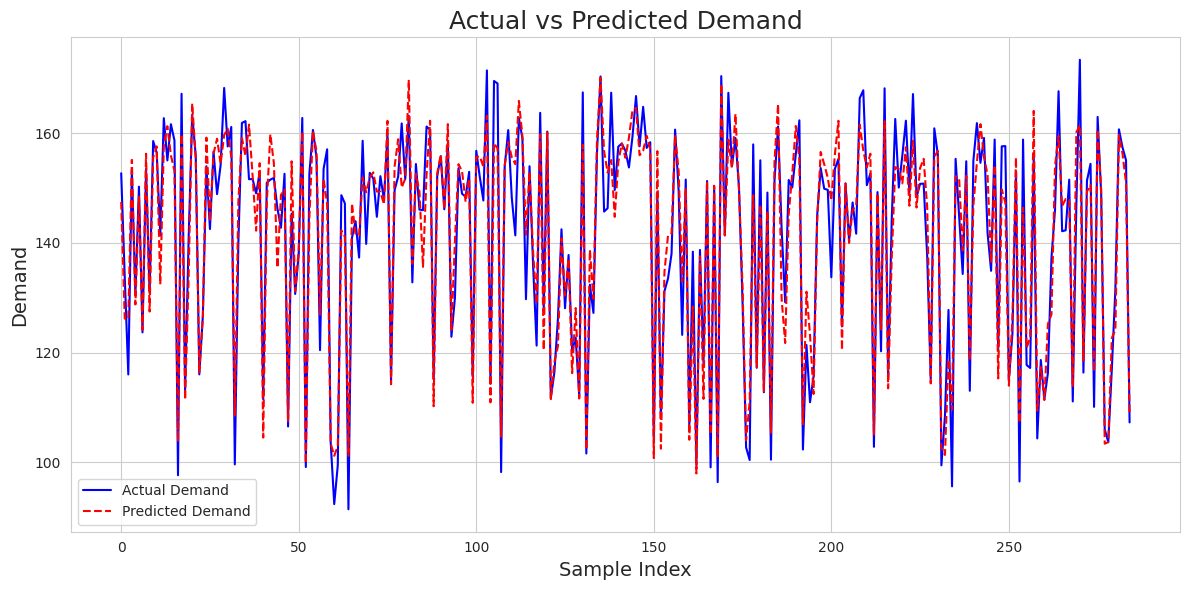

In [20]:
import pandas as pd
import numpy as np
import requests
import xgboost as xgb
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from joblib import dump

def fetch_weather_data(days=60):
    end_date = datetime.utcnow().date()
    start_date = end_date - timedelta(days=days)

    url = (
        f"https://archive-api.open-meteo.com/v1/archive?latitude=33.6844&longitude=73.0479"
        f"&start_date={start_date}&end_date={end_date}"
        f"&hourly=temperature_2m,cloudcover,windspeed_10m"
        f"&timezone=auto"
    )

    response = requests.get(url)
    response.raise_for_status()
    weather_data = response.json()

    hourly = weather_data['hourly']
    df = pd.DataFrame(hourly)
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)
    return df

def generate_synthetic_demand(df):
    np.random.seed(42)
    base_demand = 100 + df['temperature_2m'] * 2 - df['cloudcover'] * 0.5 + df['windspeed_10m'] * 0.3
    noise = np.random.normal(0, 5, len(base_demand))
    df['demand'] = base_demand + noise
    return df

def preprocess_data(df):
    df = df[['demand', 'temperature_2m', 'cloudcover', 'windspeed_10m']]
    df = df.dropna()

    features = df.drop(columns=['demand'])
    target = df['demand']

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    X_train, X_test, y_train, y_test = train_test_split(
        features_scaled, target, test_size=0.2, random_state=42
    )
    return X_train, X_test, y_train, y_test, scaler

def train_model(X_train, y_train):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )
    model.fit(X_train, y_train)
    return model

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    print(f"MAE: {mae:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.2f}")

    plt.figure(figsize=(12, 6))
    plt.plot(np.arange(len(y_test)), y_test.values, label="Actual Demand", color="blue")
    plt.plot(np.arange(len(y_pred)), y_pred, label="Predicted Demand", color="red", linestyle="--")
    plt.title("Actual vs Predicted Demand")
    plt.xlabel("Sample Index")
    plt.ylabel("Demand")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def run_pipeline(days=60):
    df = fetch_weather_data(days)
    df = generate_synthetic_demand(df)
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df)
    model = train_model(X_train, y_train)
    metrics = evaluate_model(model, X_test, y_test)

    # Save model and scaler
    dump(model, "xgb_model_demand.pkl")
    dump(scaler, "scaler.pkl")

    return df, metrics

# Run the pipeline
df, metrics = run_pipeline(days=60)


In [ ]:
!pip install entsoe-py joblib xgboost --quiet

In [21]:
# ---- IMPORTS ----
from entsoe import EntsoePandasClient
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# ---- SETUP ----
API_KEY = "5810c760-66e1-422e-981a-e9dcd36f52c8"  # Replace with your real API key
client = EntsoePandasClient(api_key=API_KEY)
country_code = 'DE'  # Germany
tz = pytz.timezone('Europe/Berlin')
end = datetime.now(tz)
start = end - timedelta(days=7)

# ---- DATA FETCHING ----
def fetch_data():
    print("📥 Fetching data from ENTSO-E...")
    try:
        demand = client.query_load(country_code, start=start, end=end)
        generation = client.query_generation(country_code, start=start, end=end, psr_type=None)

        df_demand = pd.DataFrame(demand)
        df_generation = pd.DataFrame(generation)

        df_demand.reset_index(inplace=True)
        df_generation.reset_index(inplace=True)

        df_demand.columns = ["Date", "Demand"]
        df_generation.columns = ["Date", "Supply"]

        # Merge on timestamp
        df = pd.merge(df_demand, df_generation, on="Date", how="inner")

        return df
    except Exception as e:
        print("❌ Error fetching data:", e)
        return pd.DataFrame()

# ---- MODEL TRAINING ----
def train_model():
    df = fetch_data()
    if df.empty:
        print("⚠️ No data to train on.")
        return

    print("🧹 Preprocessing data...")
    df["Hour"] = df["Date"].dt.hour
    df["DayOfWeek"] = df["Date"].dt.dayofweek

    features = ["Hour", "DayOfWeek"]
    target = "Demand"

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("📈 Training XGBoost model...")
    model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mae = mean_absolute_error(y_test, predictions)
    print(f"✅ Model trained. MAE: {mae:.2f}")

    # ---- PLOTS ----
    print("📊 Plotting actual vs predicted demand...")
    plt.figure(figsize=(12, 5))
    plt.plot(y_test.values[:100], label="Actual Demand", color='blue')
    plt.plot(predictions[:100], label="Predicted Demand", color='orange')
    plt.title("Actual vs Predicted Electricity Demand")
    plt.xlabel("Sample")
    plt.ylabel("MW")
    plt.legend()
    plt.grid(True)
    plt.show()

    print("📊 Plotting Demand vs Supply over Time...")
    plt.figure(figsize=(14, 6))
    plt.plot(df["Date"], df["Demand"], label="Demand (MW)", color='blue')
    plt.plot(df["Date"], df["Supply"], label="Supply (MW)", color='green')
    plt.title("Electricity Demand vs Supply")
    plt.xlabel("Date")
    plt.ylabel("MW")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    print("📈 Showing Demand-Supply Correlation...")
    correlation = df["Demand"].corr(df["Supply"])
    print(f"🔗 Pearson Correlation between Demand and Supply: {correlation:.4f}")

if __name__ == "__main__":
    train_model()

📥 Fetching data from ENTSO-E...
❌ Error fetching data: Please use a timezoned pandas object for start and end
⚠️ No data to train on.


In [22]:
from entsoe import EntsoePandasClient
import pandas as pd
import requests
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz
import joblib

# Set up ENTSO-E credentials and client
API_KEY = "5810c760-66e1-422e-981a-e9dcd36f52c8"  # Replace if needed
client = EntsoePandasClient(api_key=API_KEY)

COUNTRY_CODE = "LU"  # 🇱🇺 Luxembourg
LATITUDE = 49.6116
LONGITUDE = 6.1319
TIMEZONE = "Europe/Luxembourg"

def fetch_demand(start_date, end_date):
    print("⚡ Fetching electricity demand from ENTSO-E...")
    demand = client.query_load(country_code=COUNTRY_CODE, start=start_date, end=end_date)
    df = demand.reset_index()
    df.columns = ["time", "demand"]
    df["time"] = pd.to_datetime(df["time"])
    return df

def fetch_weather(start_date, end_date, latitude=LATITUDE, longitude=LONGITUDE):
    print("🌤️ Fetching weather data from Open-Meteo...")
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date.date().isoformat(),
        "end_date": end_date.date().isoformat(),
        "hourly": "temperature_2m,cloudcover,windspeed_10m",
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    data = response.json()

    if "hourly" not in data:
        raise ValueError(f"Open-Meteo API error: {data}")

    weather_df = pd.DataFrame(data["hourly"])
    weather_df["time"] = pd.to_datetime(weather_df["time"])
    return weather_df

def train_model():
    print("📥 Fetching training data...")
    tz = pytz.timezone(TIMEZONE)
    start_date = tz.localize(pd.Timestamp("2025-07-01"))
    end_date = tz.localize(pd.Timestamp("2025-07-05"))

    demand_df = fetch_demand(start_date, end_date)
    weather_df = fetch_weather(start_date, end_date)

    # Remove timezone for merging
    demand_df['time'] = demand_df['time'].dt.tz_localize(None)
    weather_df['time'] = weather_df['time'].dt.tz_localize(None)

    print("🔗 Merging data...")
    merged = pd.merge(demand_df, weather_df, on="time", how="inner")
    merged = merged.dropna()

    merged.to_csv("merged_demand_weather_luxembourg.csv", index=False)

    # Features & target
    X = merged[["temperature_2m", "cloudcover", "windspeed_10m"]]
    y = merged["demand"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("🧠 Training model...")
    model = xgb.XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1)
    model.fit(X_train, y_train)

    print("📊 Evaluating model...")
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"📉 MAE: {mae:.2f} MW")

    # Save model
    model.save_model("xgb_model_demand_luxembourg.json")  # JSON is safer for portability

    print("📈 Plotting actual vs predicted (sample)...")
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.values[:100], label="Actual", marker="o")
    plt.plot(y_pred[:100], label="Predicted", marker="x")
    plt.legend()
    plt.title("Electricity Demand Prediction")
    plt.xlabel("Sample")
    plt.ylabel("Demand (MW)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("✅ Training complete.")

    return model

def predict_next_day(model):
    print("\n📅 Predicting next day demand...")

    tz = pytz.timezone(TIMEZONE)
    tomorrow = tz.localize(pd.Timestamp("2025-07-06"))
    day_after = tz.localize(pd.Timestamp("2025-07-07"))

    weather_df = fetch_weather(tomorrow, day_after)
    weather_df['time'] = weather_df['time'].dt.tz_localize(None)

    features = weather_df[["temperature_2m", "cloudcover", "windspeed_10m"]]
    preds = model.predict(features)

    weather_df["predicted_demand"] = preds

    print(weather_df[["time", "temperature_2m", "cloudcover", "windspeed_10m", "predicted_demand"]].head(24))

    # Plot hourly forecast
    plt.figure(figsize=(14, 6))
    plt.plot(weather_df["time"], weather_df["predicted_demand"], marker='o', color="orange")
    plt.title("📊 Predicted Electricity Demand (Next Day - Hourly)")
    plt.xlabel("Time")
    plt.ylabel("Demand (MW)")
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("✅ Next day prediction complete.")

if __name__ == "__main__":
    model = train_model()
    predict_next_day(model)


📥 Fetching training data...
⚡ Fetching electricity demand from ENTSO-E...
🌤️ Fetching weather data from Open-Meteo...
🔗 Merging data...


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [23]:
 !pip install entsoe-py openmeteo-requests pandas scikit-learn matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 674.4/674.4 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.4/393.4 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.6 MB/s eta 0:00:00


In [ ]:
 pip install requests_cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.0/70.0 kB 5.2 MB/s eta 0:00:00
^C


In [ ]:
pip install requests_cache retry_requests entsoe-py pandas xgboost scikit-learn joblib

In [2]:
import pandas as pd

# Replace this with the path to your actual file
df = pd.read_csv('/content/merged_demand_weather_luxembourg.csv')  # e.g., 'day_trading_output.csv'

# Show the first few rows
df.head()


,time,demand,temperature_2m,cloudcover,windspeed_10m


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

# Optional: make sure all column names are stripped of spaces
df.columns = df.columns.str.strip()

# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])

# Set style
sns.set_style("whitegrid")

# Create a beautiful, informative multi-axis plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df['time'], y=df['demand'],
    name='Demand', line=dict(color='royalblue', width=2),
    hoverinfo='x+y'
))

fig.add_trace(go.Scatter(
    x=df['time'], y=df['temperature_2m'],
    name='Temperature (°C)', yaxis='y2',
    line=dict(color='orange', width=2, dash='dash'),
    hoverinfo='x+y'
))

fig.add_trace(go.Scatter(
    x=df['time'], y=df['cloudcover'],
    name='Cloudcover (%)', yaxis='y3',
    line=dict(color='gray', width=2, dash='dot'),
    hoverinfo='x+y'
))

fig.add_trace(go.Scatter(
    x=df['time'], y=df['windspeed_10m'],
    name='Wind Speed (km/h)', yaxis='y4',
    line=dict(color='green', width=2, dash='longdash'),
    hoverinfo='x+y'
))

# Update layout with multiple Y-axes
fig.update_layout(
    title='Daily Demand & Weather Features',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Demand', titlefont=dict(color='royalblue'), tickfont=dict(color='royalblue')),

    yaxis2=dict(title='Temperature (°C)', overlaying='y', side='right',
                titlefont=dict(color='orange'), tickfont=dict(color='orange')),

    yaxis3=dict(title='Cloudcover (%)', overlaying='y', side='left', position=0.05,
                titlefont=dict(color='gray'), tickfont=dict(color='gray')),

    yaxis4=dict(title='Wind Speed (km/h)', overlaying='y', side='right', position=0.95,
                titlefont=dict(color='green'), tickfont=dict(color='green')),

    legend=dict(orientation='h', y=1.1, x=0.5, xanchor='center'),
    height=600,
    template='plotly_white'
)

fig.show()


In [ ]:
print(df.columns)



Index(['time', 'demand', 'temperature_2m', 'cloudcover', 'windspeed_10m'], dtype='object')


📥 Fetching training data...
⚡ Fetching electricity demand from ENTSO-E...
🌤️ Fetching weather data from Open-Meteo...
🛠️ Aggregating to daily level...
🧠 Training model...
📊 Evaluating model...
📉 MAE: 4146.64 MW (Daily Total Demand)


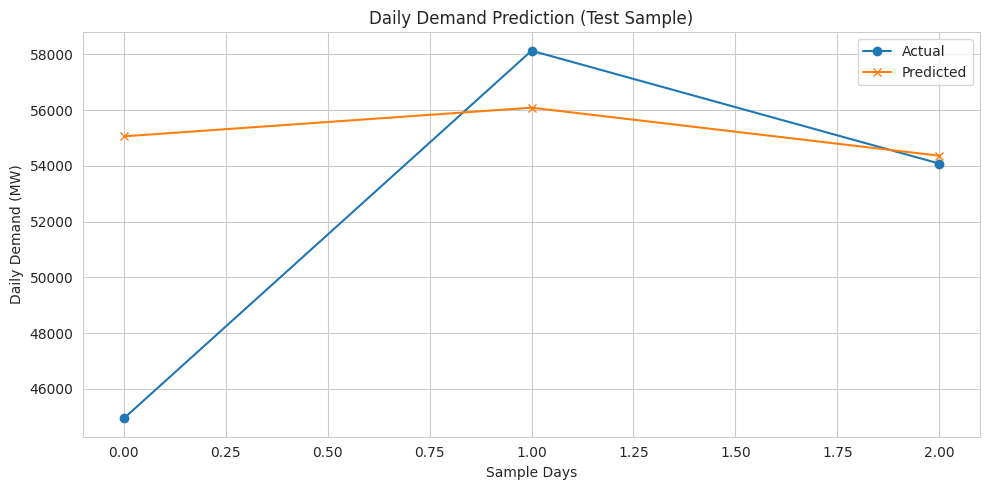

✅ Model training complete.

📅 Predicting total demand for tomorrow...
🌤️ Fetching weather data from Open-Meteo...
📈 Predicted Total Demand for 2025-07-06: 53181.70 MW


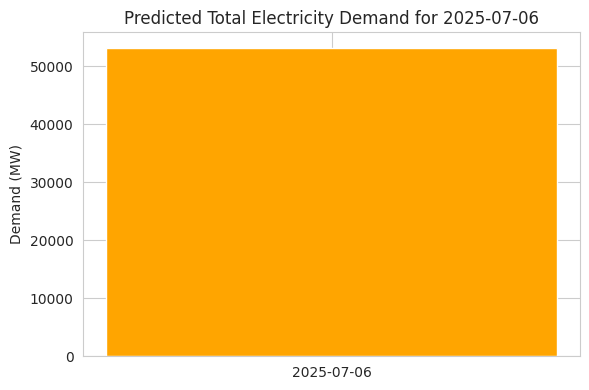

✅ Prediction complete.


In [ ]:
from entsoe import EntsoePandasClient
import pandas as pd
import requests
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import pytz

# ENTSO-E Credentials
API_KEY = "5810c760-66e1-422e-981a-e9dcd36f52c8"
client = EntsoePandasClient(api_key=API_KEY)

# Configuration
COUNTRY_CODE = "LU"  # 🇱🇺 Luxembourg
LATITUDE = 49.6116
LONGITUDE = 6.1319
TIMEZONE = "Europe/Luxembourg"

def fetch_demand(start_date, end_date):
    print("⚡ Fetching electricity demand from ENTSO-E...")
    demand = client.query_load(country_code=COUNTRY_CODE, start=start_date, end=end_date)
    df = demand.reset_index()
    df.columns = ["time", "demand"]
    df["time"] = pd.to_datetime(df["time"])
    return df

def fetch_weather(start_date, end_date):
    print("🌤️ Fetching weather data from Open-Meteo...")
    url = "https://api.open-meteo.com/v1/forecast"
    params = {
        "latitude": LATITUDE,
        "longitude": LONGITUDE,
        "start_date": start_date.date().isoformat(),
        "end_date": end_date.date().isoformat(),
        "hourly": "temperature_2m,cloudcover,windspeed_10m",
        "timezone": "auto"
    }
    response = requests.get(url, params=params)
    data = response.json()

    if "hourly" not in data:
        raise ValueError(f"Open-Meteo API error: {data}")

    weather_df = pd.DataFrame(data["hourly"])
    weather_df["time"] = pd.to_datetime(weather_df["time"])
    return weather_df

def prepare_daily_features(demand_df, weather_df):
    print("🛠️ Aggregating to daily level...")
    demand_df['time'] = demand_df['time'].dt.tz_localize(None)
    weather_df['time'] = weather_df['time'].dt.tz_localize(None)

    # Aggregate demand per day
    demand_df["date"] = demand_df["time"].dt.date
    daily_demand = demand_df.groupby("date")["demand"].sum().reset_index()

    # Aggregate weather data by daily mean
    weather_df["date"] = weather_df["time"].dt.date
    daily_weather = weather_df.groupby("date")[["temperature_2m", "cloudcover", "windspeed_10m"]].mean().reset_index()

    # Merge demand and weather
    daily_df = pd.merge(daily_demand, daily_weather, on="date", how="inner")
    return daily_df

def train_model():
    print("📥 Fetching training data...")
    tz = pytz.timezone(TIMEZONE)
    start_date = tz.localize(pd.Timestamp("2025-06-20"))
    end_date = tz.localize(pd.Timestamp("2025-07-05"))

    demand_df = fetch_demand(start_date, end_date)
    weather_df = fetch_weather(start_date, end_date)

    daily_df = prepare_daily_features(demand_df, weather_df)
    daily_df.to_csv("daily_merged_luxembourg.csv", index=False)

    X = daily_df[["temperature_2m", "cloudcover", "windspeed_10m"]]
    y = daily_df["demand"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("🧠 Training model...")
    model = xgb.XGBRegressor(n_estimators=200, max_depth=4, learning_rate=0.1)
    model.fit(X_train, y_train)

    print("📊 Evaluating model...")
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"📉 MAE: {mae:.2f} MW (Daily Total Demand)")

    # Save model
    model.save_model("xgb_model_daily_demand_luxembourg.json")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(y_test.values, label="Actual", marker='o')
    plt.plot(y_pred, label="Predicted", marker='x')
    plt.title("Daily Demand Prediction (Test Sample)")
    plt.xlabel("Sample Days")
    plt.ylabel("Daily Demand (MW)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("✅ Model training complete.")
    return model

def predict_tomorrow(model):
    print("\n📅 Predicting total demand for tomorrow...")

    tz = pytz.timezone(TIMEZONE)
    tomorrow = tz.localize(pd.Timestamp("2025-07-06"))
    day_after = tz.localize(pd.Timestamp("2025-07-07"))

    weather_df = fetch_weather(tomorrow, day_after)
    weather_df["time"] = weather_df["time"].dt.tz_localize(None)
    weather_df["date"] = weather_df["time"].dt.date

    # Aggregate weather data for the day
    daily_weather = weather_df.groupby("date")[["temperature_2m", "cloudcover", "windspeed_10m"]].mean().reset_index()
    X_pred = daily_weather[["temperature_2m", "cloudcover", "windspeed_10m"]]

    # Predict
    y_pred = model.predict(X_pred)
    predicted_day = daily_weather["date"].iloc[0]
    predicted_demand = y_pred[0]

    print(f"📈 Predicted Total Demand for {predicted_day}: {predicted_demand:.2f} MW")

    # Bar chart
    plt.figure(figsize=(6, 4))
    plt.bar([str(predicted_day)], [predicted_demand], color='orange')
    plt.title(f"Predicted Total Electricity Demand for {predicted_day}")
    plt.ylabel("Demand (MW)")
    plt.tight_layout()
    plt.show()

    print("✅ Prediction complete.")

if __name__ == "__main__":
    model = train_model()
    predict_tomorrow(model)


In [ ]:
import pandas as pd

# Replace this with the path to your actual file
df = pd.read_csv('/content/daily_merged_luxembourg.csv')  # e.g., 'day_trading_output.csv'

# Show the first few rows
df.head()

,date,demand,temperature_2m,cloudcover,windspeed_10m
0,2025-06-20,54085.0,21.370833,32.083333,11.862500
1,2025-06-21,46720.0,23.904167,46.333333,8.870833
2,2025-06-22,43557.0,25.666667,52.750000,10.854167
3,2025-06-23,42969.0,20.537500,60.875000,13.508333
4,2025-06-24,50142.0,19.116667,0.291667,11.708333


In [ ]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ---------- Load your dataframe (replace this with your actual df if needed) ----------
# Assuming you already have your DataFrame as 'df'
# Here's a dummy line in case you're testing separately:
# df = pd.read_csv("your_dataframe.csv")

# Convert time to datetime
df['date'] = pd.to_datetime(df['date'])

# ---------- Create the subplots with secondary y-axis ----------
fig = make_subplots(specs=[[{"secondary_y": True}]])

# ---------- Add Demand line ----------
fig.add_trace(
    go.Scatter(
        x=df['date'], y=df['demand'],
        mode='lines+markers',
        name='Electricity Demand',
        line=dict(color='royalblue', width=2),
        marker=dict(size=4),
        hovertemplate='Time: %{x}<br>Demand: %{y} kW'
    ),
    secondary_y=False,
)

# ---------- Add Temperature line ----------
fig.add_trace(
    go.Scatter(
        x=df['date'], y=df['temperature_2m'],
        mode='lines',
        name='Temperature (°C)',
        line=dict(color='tomato', dash='dot'),
        hovertemplate='Time: %{x}<br>Temperature: %{y}°C'
    ),
    secondary_y=True,
)

# ---------- Add Wind Speed as area plot ----------
fig.add_trace(
    go.Scatter(
        x=df['date'], y=df['windspeed_10m'],
        fill='tozeroy',
        mode='none',
        name='Wind Speed (m/s)',
        fillcolor='rgba(0, 200, 255, 0.3)',
        hovertemplate='Time: %{x}<br>Wind Speed: %{y} m/s'
    ),
    secondary_y=False,
)

# ---------- Customize layout ----------
fig.update_layout(
    title={
        'text': '📊 Daily Energy Demand vs Weather Conditions',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Date & Time',
    yaxis_title='Electricity Demand (kW)',
    legend=dict(
        bgcolor='rgba(255,255,255,0)',
        bordercolor='black',
        borderwidth=1,
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    plot_bgcolor='white',
    hovermode='x unified',
    font=dict(family="Arial", size=12),
    height=600
)

fig.update_yaxes(title_text="Electricity Demand (kW)", secondary_y=False, showgrid=True, gridcolor='lightgrey')
fig.update_yaxes(title_text="Temperature (°C)", secondary_y=True, showgrid=False)

# ---------- Show Plot ----------
fig.show()
